In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow_model_optimization.python.core.quantization.keras.quantize_wrapper import QuantizeWrapper


import tempfile
import os



In [4]:

# Load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape the data to 32x32x3 and normalize it
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=-1))
x_train = tf.image.resize(x_train, (32, 32))
x_train = x_train / 255.0
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=-1))
x_test = tf.image.resize(x_test, (32, 32))
x_test = x_test / 255.0


In [5]:
(train_images_rgb, train_labels), (test_images_rgb, test_labels) = (x_train, y_train), (x_test, y_test)
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [6]:

# Define MobileNet model
inputs = Input(shape=(32, 32, 3))
base_model = MobileNet(input_tensor=inputs, include_top=False, weights=None, pooling='avg')
mid = Dense(128, activation='relu')(base_model.output)
x = Dropout(0.25)(mid)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

# Train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [7]:

# Fit the model with the learning rate scheduler
model.fit(train_images_rgb, train_labels, epochs=1, validation_split = 0.2)


1500/1500 [==============================] - 283s 187ms/step - loss: 0.7925 - accuracy: 0.7222 - val_loss: 0.4845 - val_accuracy: 0.8287


In [8]:
# Evaluate the model
score = model.evaluate(test_images_rgb, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.5009627938270569
Test accuracy: 0.8273000121116638


In [9]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer


class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
        # Add this line for each item returned in `get_weights_and_quantizers`
        # , in the same order
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
        # Add this line for each item returned in `get_activations_and_quantizers`
        # , in the same order.
        layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
        return []

    def get_config(self):
        return {}


In [20]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

all_qat_models = []
rng = range(4, 17, 2)

for n_bits in tqdm(rng):
    class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):

        # Configure weights to quantize with n-bit instead of 8-bits.
        def get_weights_and_quantizers(self, layer):
            return [(layer.kernel, LastValueQuantizer(num_bits=n_bits, symmetric=True, narrow_range=False, per_axis=False))]

    def apply_quantization_to_dense(layer):
        if type(layer) in [keras.layers.Dense]:
            return quantize_annotate_layer(layer)
        return layer

    inputs = Input(shape=(32, 32, 3))
    base_model = MobileNet(input_tensor=inputs, include_top=False, weights=None, pooling='avg')
    x = Dropout(0.25)(base_model.output)
    outputs = Dense(10, activation='softmax')(x)
    curr_model = Model(inputs, outputs)

    annotated_model = tf.keras.models.clone_model(
        curr_model,
        clone_function=apply_quantization_to_dense,
    )

    qat_model = quantize_annotate_model(annotated_model)

    # `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
    with quantize_scope(
            {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
        # Use `quantize_apply` to actually make the model quantization aware.
        qat_model = tfmot.quantization.keras.quantize_apply(qat_model)

    qat_model.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                from_logits=True),
                            metrics=['accuracy'])

    qat_model.fit(train_images_rgb, y_train, epochs=1, validation_split = 0.2, verbose=0)

    all_qat_models.append(qat_model)

all_qat_models[0].summary()

100%|██████████| 7/7 [45:49<00:00, 392.81s/it]

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 quantize_layer_9 (QuantizeL  (None, 32, 32, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv1 (QuantizeWrappe  (None, 16, 16, 32)       929       
 rV2)                                                            
                                                                 
 quant_conv1_bn (QuantizeWra  (None, 16, 16, 32)       129       
 pperV2)                                                         
                                                                 
 quant_conv1_relu (QuantizeW  (None, 16, 16, 32)       3         
 rapperV2)                                                

In [24]:
_, baseline_model_accuracy = model.evaluate(test_images_rgb, test_labels, verbose=0)
all_qat_accs = []

for qat_model in all_qat_models:
    _, qat_model_accuracy = qat_model.evaluate(test_images_rgb, y_test, verbose=0)
    all_qat_accs.append(round(qat_model_accuracy, 4))

print(f"Model Test Accuracy (without Quantization) \t: {baseline_model_accuracy:.4f}")
print(f"QAT Models Test Accuracy (without Quantization) : \n{all_qat_accs}")


Model Test Accuracy (without Quantization) 	: 0.8572
QAT Models Test Accuracy (without Quantization) : 
[0.7419, 0.8046, 0.8311, 0.7919, 0.816, 0.8422, 0.8308]


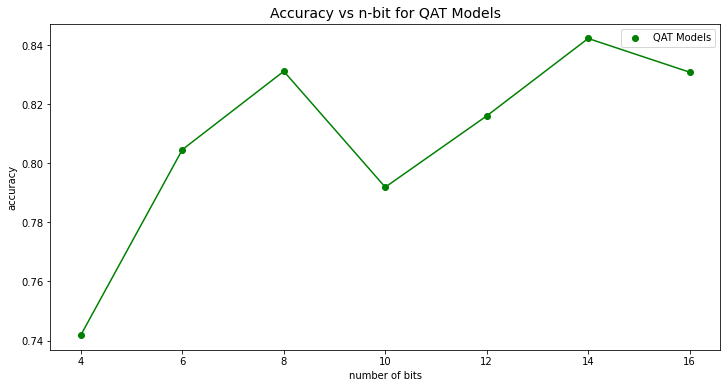

In [22]:
plt.figure(figsize=(12, 6))
plt.title('Accuracy vs n-bit for QAT Models', fontsize=14)
plt.plot(rng, all_qat_accs, color='green')
plt.scatter(rng, all_qat_accs, color='green', label='QAT Models')
plt.xlabel('number of bits')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [25]:
d = {'Models':['Float Model']+[f'{n}-bit QAT Model' for n in rng], 'Accuracies':[baseline_model_accuracy]+all_qat_accs}
table = pd.DataFrame(d)

table

,Models,Accuracies
0,Float Model,0.8572
1,4-bit QAT Model,0.7419
2,6-bit QAT Model,0.8046
3,8-bit QAT Model,0.8311
4,10-bit QAT Model,0.7919
5,12-bit QAT Model,0.8160
6,14-bit QAT Model,0.8422
7,16-bit QAT Model,0.8308


In [26]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()
float_model_size = len(float_tflite_model) / float(2**20)

converter = tf.lite.TFLiteConverter.from_keras_model(all_qat_models[1])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

float_model_size = len(float_tflite_model) / float(2**20)
qat_model_size = len(quantized_tflite_model) / float(2**20)

INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpd20zy1p6\assets


INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpminziook\assets


INFO:tensorflow:Assets written to: C:\Users\YASHMA~1\AppData\Local\Temp\tmpminziook\assets


In [28]:

print(f"Float model size \t: {float_model_size:.4f} mb")
print(f"8-bit QAT Model size \t: {qat_model_size:.4f} mb")

Float model size 	: 12.7128 mb
8-bit QAT Model size 	: 3.3596 mb


In [73]:
def evaluate_model(model):
    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images_rgb[:2000]):
        if i % 500 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)

    corrects = 0
    for x in range(len(prediction_digits)):
        if prediction_digits[x]==y_test[x]:
            corrects+=1
    return corrects/len(prediction_digits)


In [74]:
quantized_tflite_model_accuracy = evaluate_model(quantized_tflite_model)
float_tflite_model_accuracy = evaluate_model(float_tflite_model)

Evaluated on 0 results so far.
Evaluated on 500 results so far.
Evaluated on 1000 results so far.
Evaluated on 1500 results so far.


Evaluated on 0 results so far.
Evaluated on 500 results so far.
Evaluated on 1000 results so far.
Evaluated on 1500 results so far.




In [75]:
print(f"Float TFLite test_accuracy (without Quantization) \t : {float_tflite_model_accuracy:.4f}")
print(f"QAT TFLite test_accuracy (with 8-bit Quantization) \t : {quantized_tflite_model_accuracy:.4f}")


Float TFLite test_accuracy (without Quantization) 	 : 0.8345
QAT TFLite test_accuracy (with 8-bit Quantization) 	 : 0.7400
